In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils

In [2]:
img_orig = cv2.imread(r'C:\Users\Shubham\clg project\2_DocumentSacanner\images\001.jpg')

In [3]:
cv2.namedWindow('original',cv2.WINDOW_NORMAL)
cv2.imshow('original',img_orig)
cv2.waitKey(0)
cv2.destroyAllWindows()

# scanning
# resizing the image and set aspect ratio

In [4]:
def resizer(image,width=500):
    #get width and height
    h,w,c = image.shape
    
    height = int((h/w) * width)
    size = (width,height)
    image = cv2.resize(image,(width,height))
    return image,size

In [5]:
img_re,size = resizer(img_orig)
print(size)
cv2.imshow('resize',img_re)
cv2.waitKey()
cv2.destroyAllWindows()

(500, 347)


In [6]:
#enhance
detail = cv2.detailEnhance(img_re,sigma_s = 20, sigma_r =0.15)

#grayscale
gray = cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY)

#blur
blur = cv2.GaussianBlur(gray,(5,5),0)
#edge detection
edge_image = cv2.Canny(blur,75,200)
#morphological transform
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(edge_image,kernel,iterations=1)
closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)

# contours
contours , hire = cv2.findContours(closing,
                                   cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_SIMPLE) 

contours = sorted(contours,key=cv2.contourArea,reverse=True)
for contour in contours:
    peri = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,0.02*peri,True)
    
    if len(approx) == 4:
        four_points = np.squeeze(approx)
        break
        
cv2.drawContours(img_re,[four_points],-1,(0,255,0),3)

#find four points for original image  
multiplier = img_orig.shape[1] / size[0]
four_point_orig = four_points * multiplier
four_point_orig = four_point_orig.astype(int)


In [7]:
four_point_orig

array([[1058,  108],
       [1048,  703],
       [ 134,  691],
       [ 134,  112]])

In [8]:
from imutils.perspective import four_point_transform

In [9]:
wrap_image = four_point_transform(img_orig,four_point_orig)

In [10]:
cv2.imshow('wrap',wrap_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# document scanning function

In [11]:
def document_scanner(image):

    img_re,size = resizer(image)
    #enhance
    detail = cv2.detailEnhance(img_re,sigma_s = 20, sigma_r =0.15)
    #grayscale
    gray = cv2.cvtColor(detail,cv2.COLOR_BGR2GRAY)
    #blur
    blur = cv2.GaussianBlur(gray,(5,5),0)
    #edge detection
    edge_image = cv2.Canny(blur,75,200)
    #morphological transform
    kernel = np.ones((5,5),np.uint8)
    dilate = cv2.dilate(edge_image,kernel,iterations=1)
    closing = cv2.morphologyEx(dilate,cv2.MORPH_CLOSE,kernel)

    # contours
    contours , hire = cv2.findContours(closing,
                                       cv2.RETR_LIST,
                                       cv2.CHAIN_APPROX_SIMPLE) 

    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    for contour in contours:
        peri = cv2.arcLength(contour,True)
        approx = cv2.approxPolyDP(contour,0.02*peri,True)

        if len(approx) == 4:
            four_points = np.squeeze(approx)
            break

    cv2.drawContours(img_re,[four_points],-1,(0,255,0),3)

    #find four points for original image  
    multiplier = image.shape[1] / size[0]
    four_point_orig = four_points * multiplier
    four_point_orig = four_point_orig.astype(int)

    wrap_image = four_point_transform(image,four_point_orig)
    
    return wrap_image, four_point_orig ,img_re ,closing

In [12]:
img = cv2.imread('./images/001.jpg')
wrpimg,points,cnt_img,edgeimg = document_scanner(img)

In [13]:
cv2.imshow('original',img)
cv2.imshow('resize',cnt_img)
cv2.imshow('edge',edgeimg)
cv2.imshow('wrap',wrpimg)
cv2.waitKey()
cv2.destroyAllWindows()

# magic color

In [14]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [15]:
rgb = cv2.cvtColor(wrpimg,cv2.COLOR_BGR2RGB)
magic_image = apply_brightness_contrast(rgb,120,0)
magic_image_c1 = apply_brightness_contrast(rgb,0,40)
magic_image_c2 = apply_brightness_contrast(rgb,50,40)

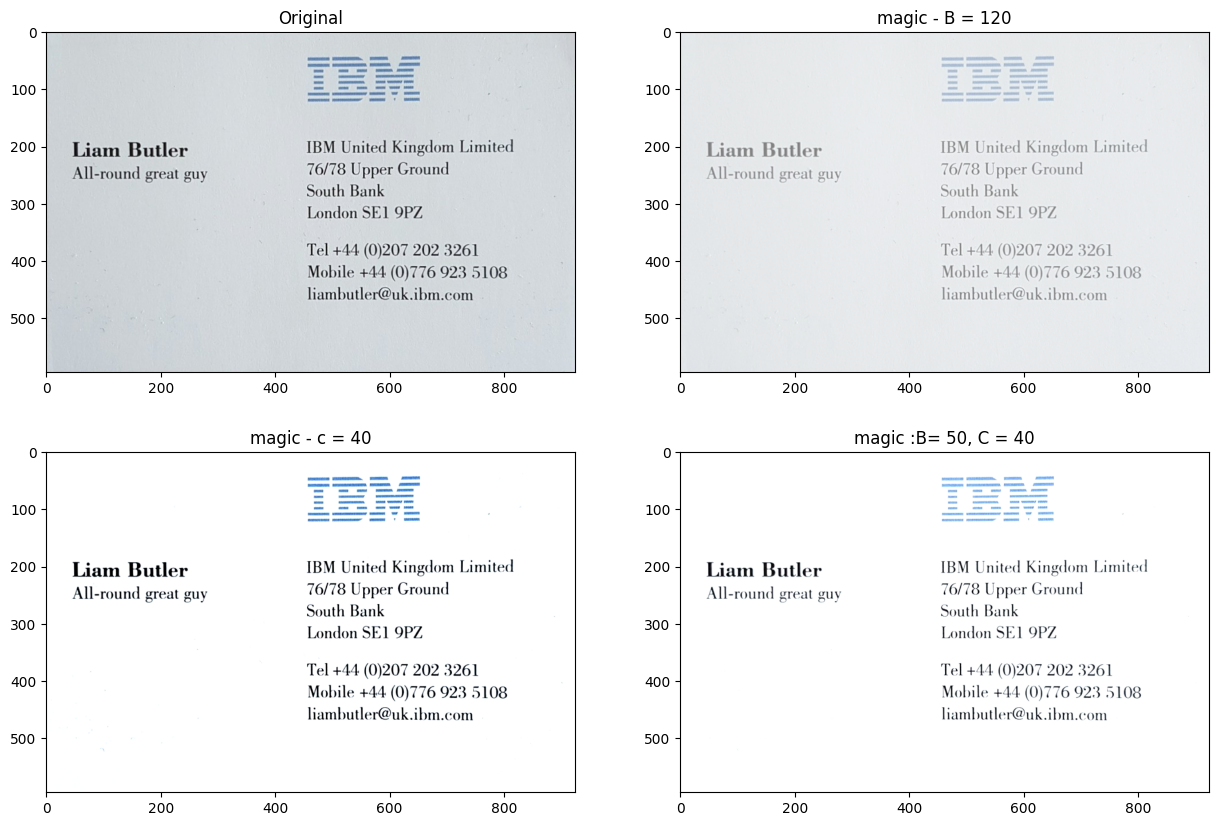

In [16]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(rgb)
plt.title('Original')

plt.subplot(2,2,2)
plt.imshow(magic_image)
plt.title('magic - B = 120')

plt.subplot(2,2,3)
plt.imshow(magic_image_c1)
plt.title('magic - c = 40')

plt.subplot(2,2,4)
plt.imshow(magic_image_c2)
plt.title('magic :B= 50, C = 40')
plt.show()

# predictions

In [17]:
import predictions as pred

In [18]:
img_bb,results = pred.getPredictions(magic_image_c2)

liam butler all-round great guy ibm united kingdom limited 76/78 upper ground south bank london se1 9pz tel 44 0207 202 3261 mobile 44 0776 923 5108 liambutler@uk.ibm.com


In [19]:
cv2.namedWindow('predictions',cv2.WINDOW_NORMAL)
cv2.imshow('predictions',img_bb)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [20]:
results

{'NAME': ['Kingdom', 'Pz'],
 'ORG': [],
 'DES': [],
 'ADD': ['7678 Upper Ground'],
 'PHONE': ['440207', '440776'],
 'EMAIL': ['liambutler@uk.ibm.com'],
 'WEB': []}